In [2]:
'''
5.3.2 GRU - PyTorch (sin波)
'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optimizers
from callbacks import EarlyStopping


class RNN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.l1 = nn.GRU(1, hidden_dim,
                         batch_first=True)
        self.l2 = nn.Linear(hidden_dim, 1)

        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0)

    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:, -1])
        return y


<AxesSubplot:>

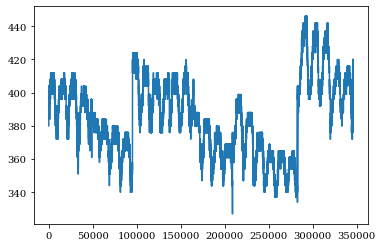

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("data.csv")
co2 = df['CO2']
def lowcut(_df, th):
    _df = _df.copy()
    n = len(_df)    
    for i in range(n):
        x = _df.iloc[i]
        if x < th:
            _df.iloc[i] = _df.iloc[i-1]    
    return _df        
th = 330
co2_pre = lowcut(co2, 325)
co2_pre.plot()

In [29]:
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
maxlen = 25
remove = len(co2_pre)%maxlen
length_of_sequences = len(co2_pre)-remove

x = []
t = []

for i in range(length_of_sequences - maxlen):
    x.append(co2_pre[i:i+maxlen])
    t.append(co2_pre[i+maxlen])

x = np.array(x).reshape(-1, maxlen, 1)
t = np.array(t).reshape(-1, 1)


x_train, x_val, t_train, t_val = \
    train_test_split(x, t, test_size=0.2, shuffle=False)

'''
2. モデルの構築
'''
model = RNN(50).to(device)

'''
3. モデルの学習
'''
criterion = nn.MSELoss(reduction='mean')
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), amsgrad=True)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds


In [ ]:
epochs = 1000
batch_size = 100
n_batches_train = x_train.shape[0] // batch_size + 1
n_batches_val = x_val.shape[0] // batch_size + 1
hist = {'loss': [], 'val_loss': []}
es = EarlyStopping(patience=10, verbose=1)

for epoch in range(epochs):
    train_loss = 0.
    val_loss = 0.
    x_, t_ = shuffle(x_train, t_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = train_step(x_[start:end], t_[start:end])
        train_loss += loss.item()

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = val_step(x_val[start:end], t_val[start:end])
        val_loss += loss.item()

    train_loss /= n_batches_train
    val_loss /= n_batches_val

    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)

    print('epoch: {}, loss: {:.3}, val_loss: {:.3f}'.format(
        epoch+1,
        train_loss,
        val_loss
    ))

    if es(val_loss):
        break

epoch: 1, loss: 1.09e+05, val_loss: 93348.532
epoch: 2, loss: 5.63e+04, val_loss: 50207.592
epoch: 3, loss: 2.81e+04, val_loss: 27636.100
epoch: 4, loss: 1.41e+04, val_loss: 15813.778
epoch: 5, loss: 7.17e+03, val_loss: 9511.061
epoch: 6, loss: 3.73e+03, val_loss: 6075.031
epoch: 7, loss: 2.03e+03, val_loss: 4151.698
epoch: 8, loss: 1.19e+03, val_loss: 3042.926
epoch: 9, loss: 7.68e+02, val_loss: 2383.832
epoch: 10, loss: 5.61e+02, val_loss: 1980.194
epoch: 11, loss: 4.59e+02, val_loss: 1725.741
epoch: 12, loss: 4.08e+02, val_loss: 1561.506
epoch: 13, loss: 3.83e+02, val_loss: 1453.173
epoch: 14, loss: 3.71e+02, val_loss: 1380.714
epoch: 15, loss: 3.65e+02, val_loss: 1331.439
epoch: 16, loss: 3.62e+02, val_loss: 1297.531
epoch: 17, loss: 3.6e+02, val_loss: 1274.298
epoch: 18, loss: 3.59e+02, val_loss: 1257.909
epoch: 19, loss: 3.59e+02, val_loss: 1246.657
epoch: 20, loss: 3.59e+02, val_loss: 1238.849
epoch: 21, loss: 3.59e+02, val_loss: 1233.121
epoch: 22, loss: 3.59e+02, val_loss: 122

In [ ]:
'''
4. モデルの評価
'''
model.eval()

# sin波の予測
sin = toy_problem(T, ampl=0.)
gen = [None for i in range(maxlen)]

z = x[:1]

for i in range(length_of_sequences - maxlen):
    z_ = torch.Tensor(z[-1:]).to(device)
    preds = model(z_).data.cpu().numpy()
    z = np.append(z, preds)[1:]
    z = z.reshape(-1, maxlen, 1)
    gen.append(preds[0, 0])

# 予測値を可視化
fig = plt.figure()
plt.rc('font', family='serif')
plt.xlim([0, 2*T])
plt.ylim([-1.5, 1.5])
plt.plot(range(len(f)), sin,
         color='gray',
         linestyle='--', linewidth=0.5)
plt.plot(range(len(f)), gen,
         color='black', linewidth=1,
         marker='o', markersize=1, markerfacecolor='black',
         markeredgecolor='black')
# plt.savefig('output.jpg')
plt.show()